### Lab 4

In [23]:
# Necessary imports for code to run
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy import stats
from scipy.optimize import curve_fit
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (20,15)

In [9]:
# Importing data to working environment
hf = h5py.File('gammaray_lab4.h5', 'r')

In [5]:
hf.keys()

<KeysViewHDF5 ['data']>

In [6]:
data = np.array(hf.get('data'))

In [7]:
data[:,0]

array([9.40680016e+08, 3.15000000e+02, 4.50000000e+01, 1.00000000e+01])

In [8]:
hf.close()

### Problem 1

### 1.1:

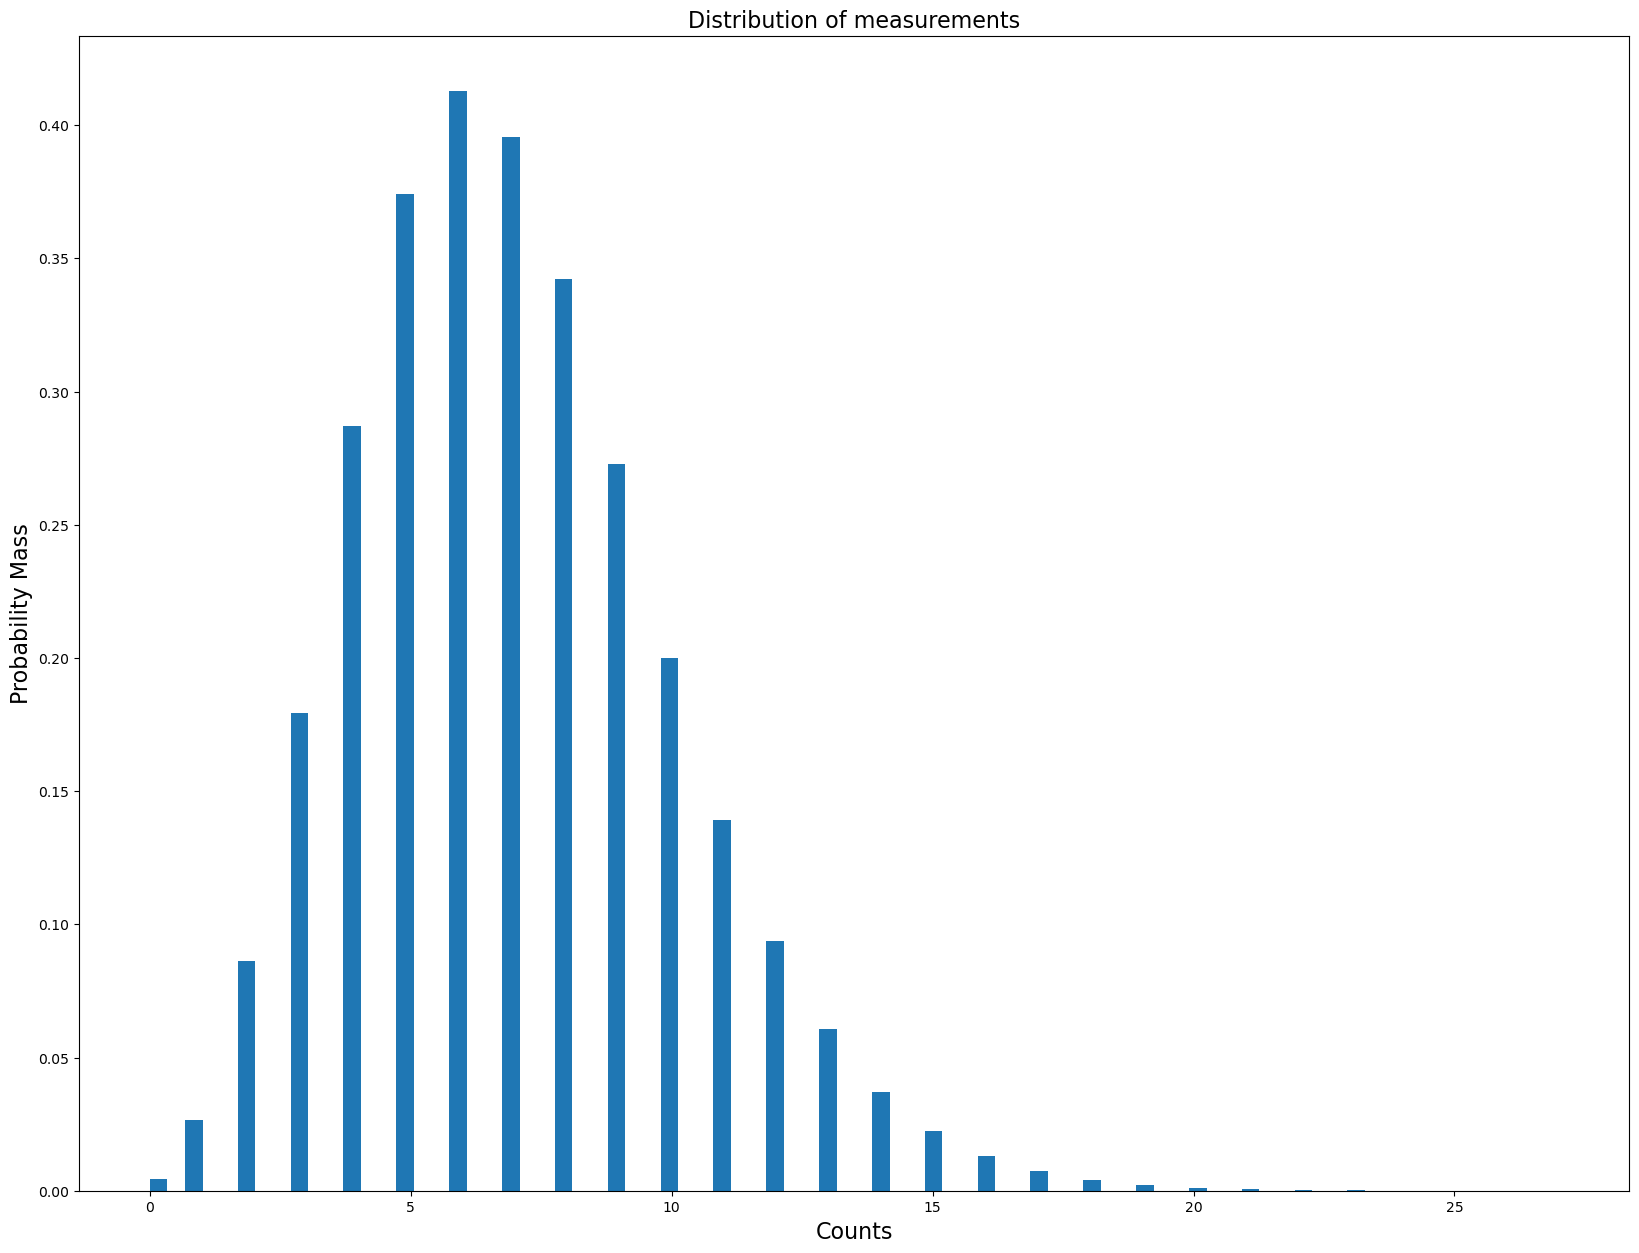

In [12]:
plt.title('Distribution of measurements', fontsize = 16)
plt.xlabel('Counts', fontsize = 16)
plt.ylabel('Probability Mass', fontsize = 16)
plt.hist(data[3][0:400000], bins = 80, density = True);
plt.show()

I plotted the first 400k points just to get an idea of what the data looks like. This looks like a discrete distribution, which makes sense because each measurement represents discrete number of events seen in a certain time interval. It looks like a poisson distribution with a mean of 6. To confirm that the distribution is indeed Poisson, we must plot the distribution on a semilog axis and compare its shape to that of an actual Poisson distribution.

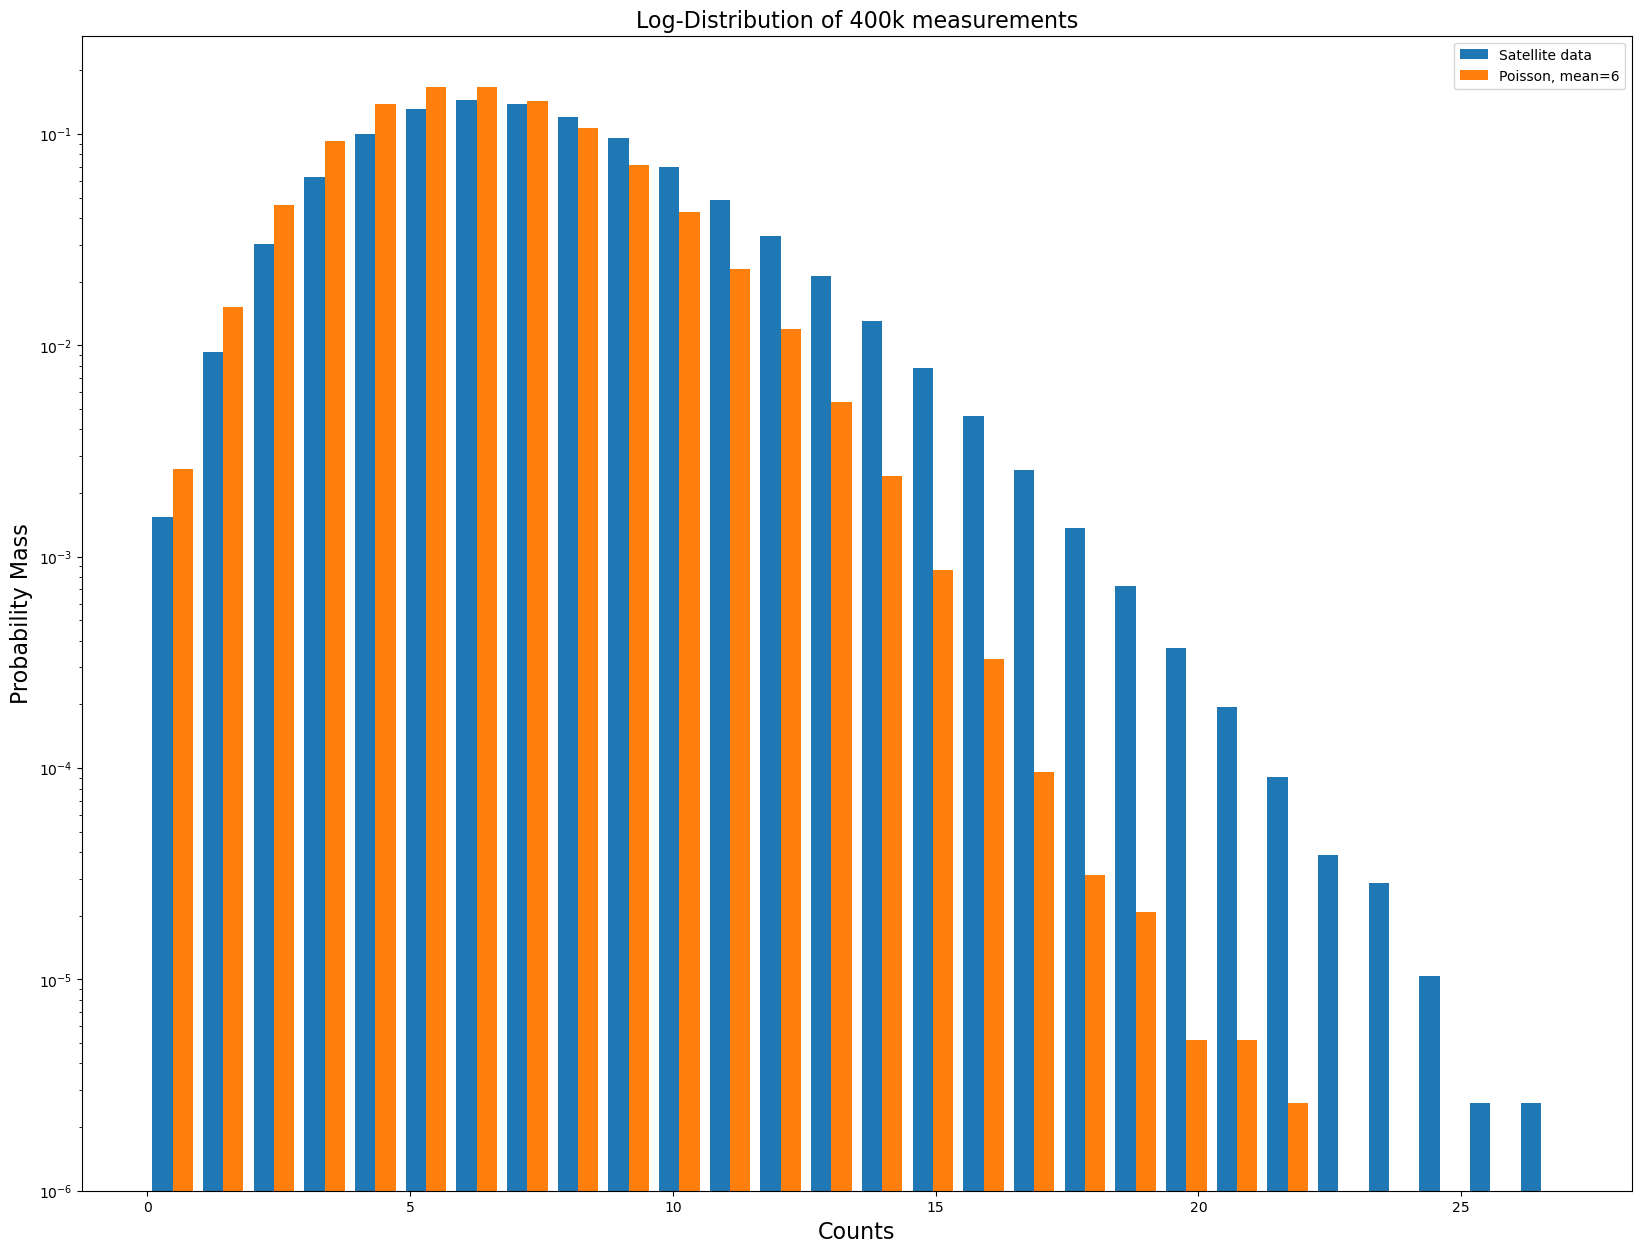

In [16]:
plt.title("Log-Distribution of 400k measurements", fontsize = 16)
plt.xlabel('Counts', fontsize = 16)
plt.ylabel('Probability Mass', fontsize = 16)
dist = stats.poisson(6)
vals = dist.rvs(400000)
plt.hist([data[3][0:400000], vals], bins = 28, density = True)
plt.yscale('log')
plt.ylim(1e-6, None)
plt.legend(['Satellite data', 'Poisson, mean=6']);
plt.show()

From looking at the semilog plot, it is apparant that the data does not follow an exact Poisson distribution, as evident from the different end behavior at the right tail of the data. This does not necesarrily mean that there is signal contamination, however. It just means that the mean of
the Poisson distribution is changing with time.

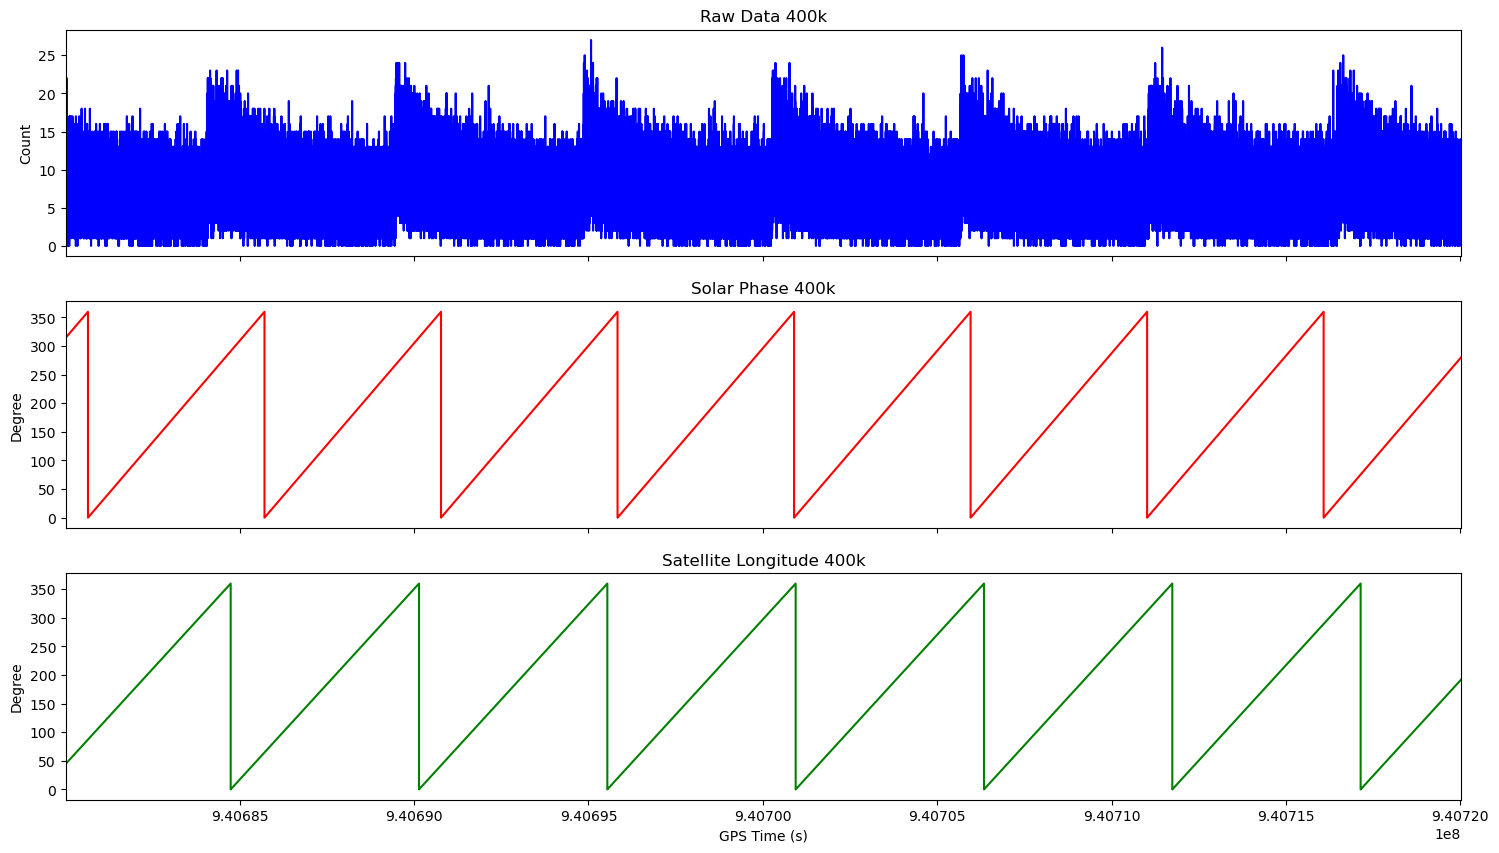

In [17]:
fig,ax = plt.subplots(3, 1, figsize = (18, 10), sharex = True)
ax[0].set_title("Raw Data 400k") 
ax[0].set_ylabel("Count")
ax[0].plot(data[0][0:400000], data[3][0:400000], color = 'b')
ax[0].set_xlim(data[0][0], data[0][400000])
ax[1].set_title("Solar Phase 400k")
ax[1].set_ylabel("Degree")
ax[1].plot(data[0][0:400000], data[1][0:400000], color = 'r')
ax[1].set_xlim(data[0][0], data[0][400000])
ax[2].set_title("Satellite Longitude 400k")
ax[2].set_ylabel("Degree")
ax[2].set_xlabel("GPS Time (s)")
ax[2].plot(data[0][0:400000], data[2][0:400000], color = 'g')
ax[2].set_xlim(data[0][0], data[0][400000])
plt.show()

From the graphs we can see that the raw data has a cyclic dependency with time. It appears that the solar phase's longitudal lines line up closely with the periodic spikes in the raw data. Therefore there is some location-related issue that is causing the spikes in the raw data.

### 1.2:

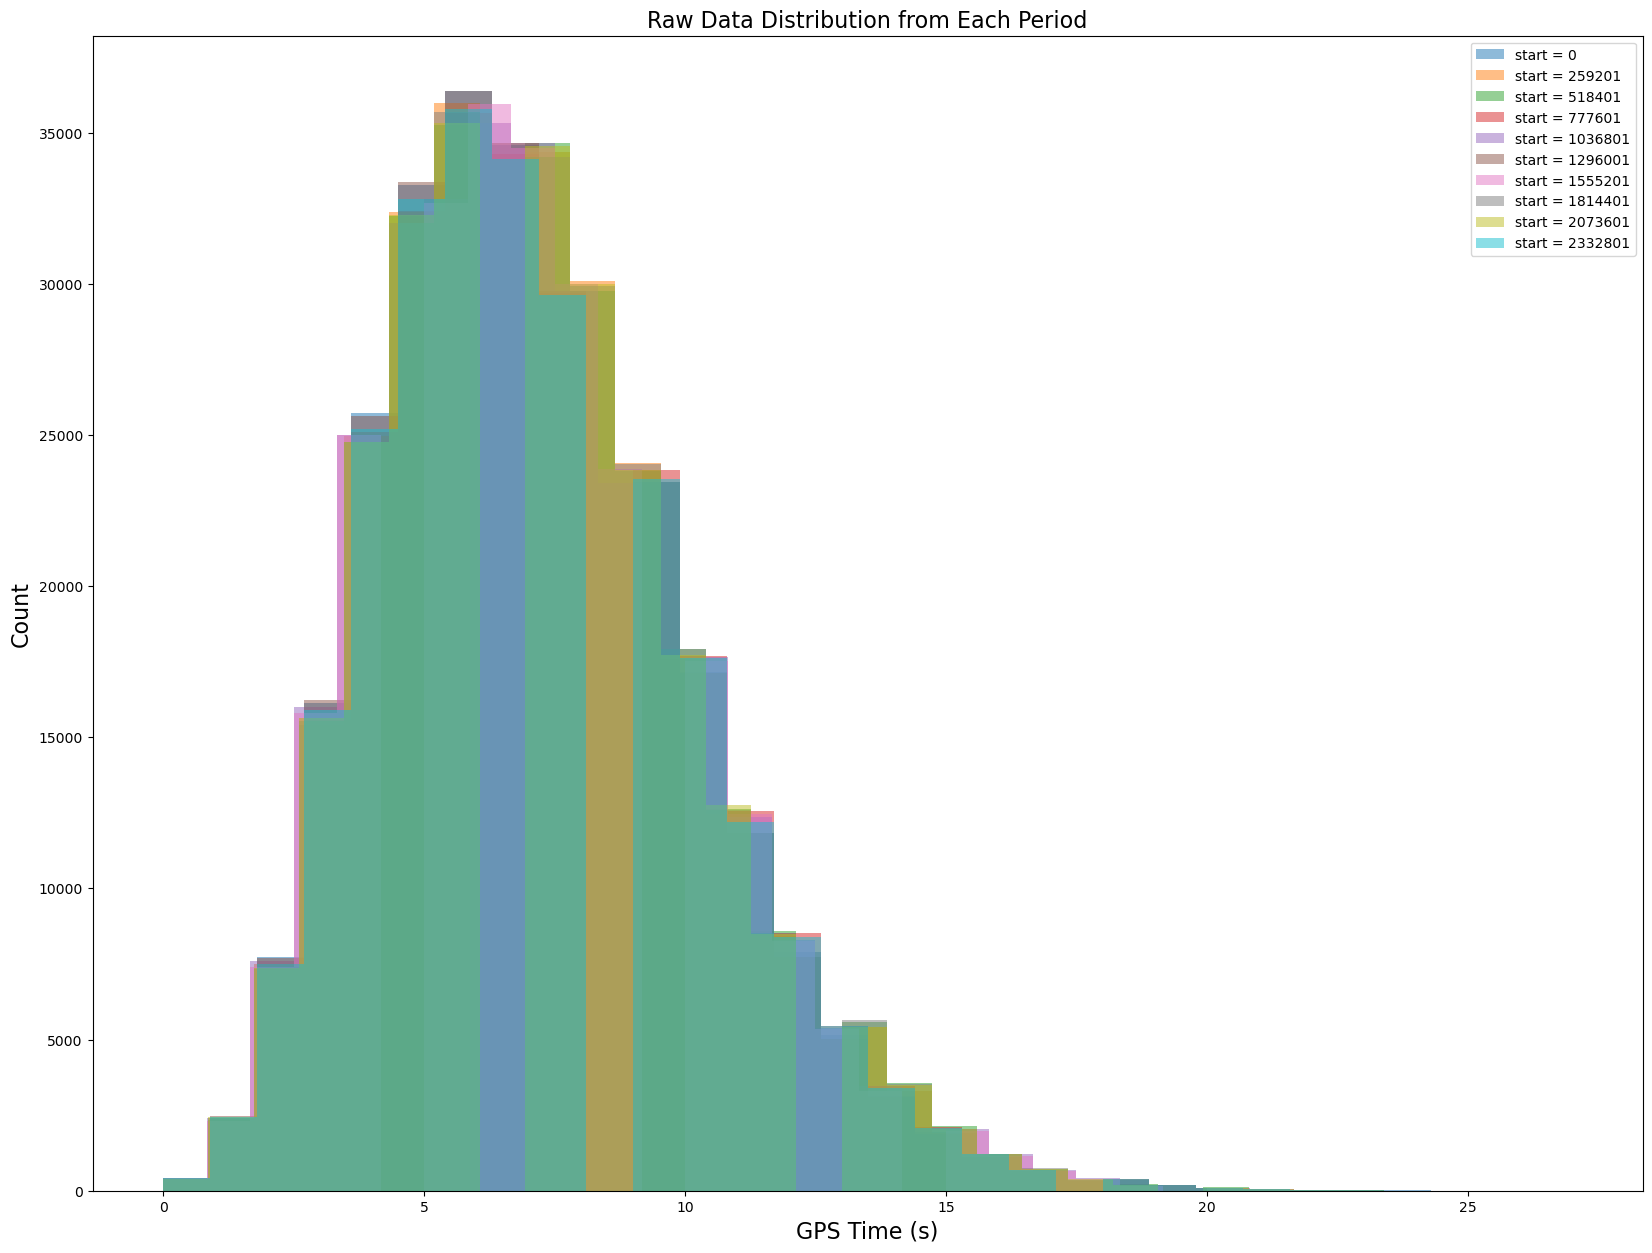

In [19]:
counts = data[3,:]
counts_length = len(counts)
stops = []
for i in range(10):
    stops.append(int((i + 1) * (counts_length / 100)))
for i in range(len(stops)):
    if i == 0:
        start = 0
    else:
        start = stops[i - 1] + 1
    stop = stops[i]
    plt.hist(counts[start:stop], 30, alpha=0.5, label='start = ' + str(start))
plt.title("Raw Data Distribution from Each Period", fontsize = 16)
plt.xlabel("GPS Time (s)", fontsize = 16)
plt.ylabel("Count", fontsize = 16)
plt.legend(loc='best')
plt.show()

Above is the distribution of the data set in each period, this showcases that the distribution isn't constant. Overall each periods last around 40,000 seconds. If we average all the full periods from the entire data set we can get the average period, which we can then fit to a function to find a good approx of the background over one period of counts. By calculating the average, we can eliminate the massive impact of any possible outliers.

### 1.3:

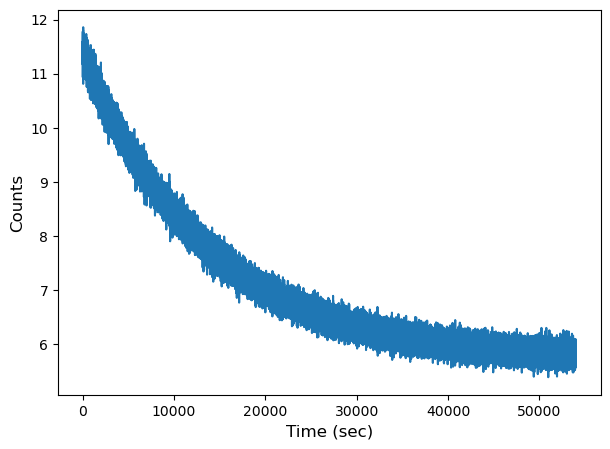

In [20]:
counts = counts[40500:]
period = 54000
counts_parts = []
average_counts = []
for i in range(400):
    start = i * period
    stop = (i + 1) * period
    counts_parts.append(np.array(counts[start:stop]))
    average_counts.append(np.true_divide(np.sum(counts[start:stop]), len(counts[start:stop])))
averaged_data = np.zeros(54000)
total_parts = len(counts_parts)
for part in counts_parts:
    averaged_data = np.add(averaged_data, part)
averaged_data = np.true_divide(averaged_data, total_parts)
time_for_average = np.arange(0, period)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(time_for_average, averaged_data)
ax.set_xlabel('Time (sec)', fontsize='large')
ax.set_ylabel('Counts', fontsize='large')
plt.show()

Above is the averaged period in which I'm going to fit a function to. I'm going to use that as the background. The overall trend looks like a decaying exponential. There's an issue that the time scale is super large, so we must reduce it so the computer can handle it.

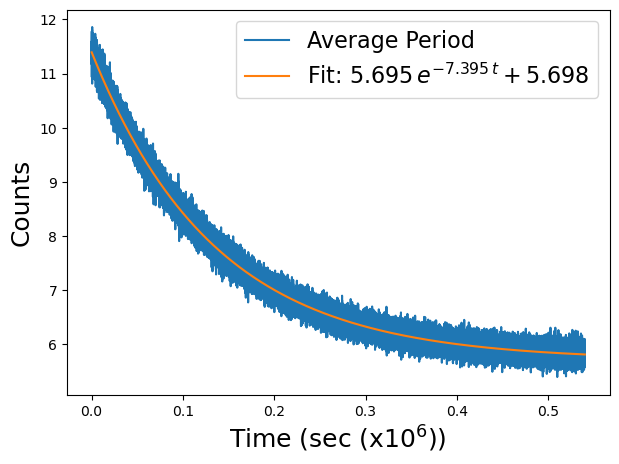

In [24]:
def func(x, a, b, c):
    return a * np.exp(-b * x) + c
reduced_time = np.linspace(0, period / 100000, period)
popt, pcov = curve_fit(func, reduced_time, averaged_data)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.plot(reduced_time, averaged_data, label='Average Period')
ax.plot(reduced_time, func(reduced_time, *popt), label='Fit: $%5.3f\,e^{-%5.3f\,t} + %5.3f$' % tuple(popt))
ax.set_xlabel('Time (sec (x$10^{6}$))', fontsize=18)
ax.set_ylabel('Counts', fontsize=18)
ax.legend(loc='best', fontsize=16)
plt.show()

To fit the curve I scaled the time by 10^6 then used the optimize function to fit the function of $N(t)=a\,e^{-b t}+c$. That is shown in the orange line. And it fits nicely, so it looks like a good approximation of the background.

### 1.4:

In [28]:
prob = stats.norm.cdf(5)
signal1 = stats.poisson.ppf(prob, average_counts[1])
signal2 = stats.poisson.ppf(prob, average_counts[27])
signal3 = stats.poisson.ppf(prob, average_counts[299])
print('Average number of counts for 2nd period =', average_counts[1])
print('Average number of counts for 28th period =', average_counts[27])
print('Average number of counts for 300th period =', average_counts[299])
print()
print('5 sigma for 2nd Period = %5.2f gamma rays' % signal1)
print('5 sigma for 28th Period = %5.2f gamma rays' % signal2)
print('5 sigma for 300th Period = %5.2f gamma rays' % signal3)

Average number of counts for 2nd period = 7.124314814814815
Average number of counts for 28th period = 7.087018518518518
Average number of counts for 300th period = 7.0979074074074076

5 sigma for 2nd Period = 24.00 gamma rays
5 sigma for 28th Period = 24.00 gamma rays
5 sigma for 300th Period = 24.00 gamma rays


For the 2nd period, the number of gamma rays needed to have a 5 sigma significance is 24. Same for the 28th and 300th periods. This seemed very strange so I printed out the average number of counts per period, and they aren't all the same. So the decimals of the number of rays must be very insignificant.

### Problem 2

### 2.1:

In [34]:
# Downloading data from images.h5
with h5py.File('images.h5', 'r') as hf:
    img_data = np.array(hf.get('imagestack'))

### 2.2:

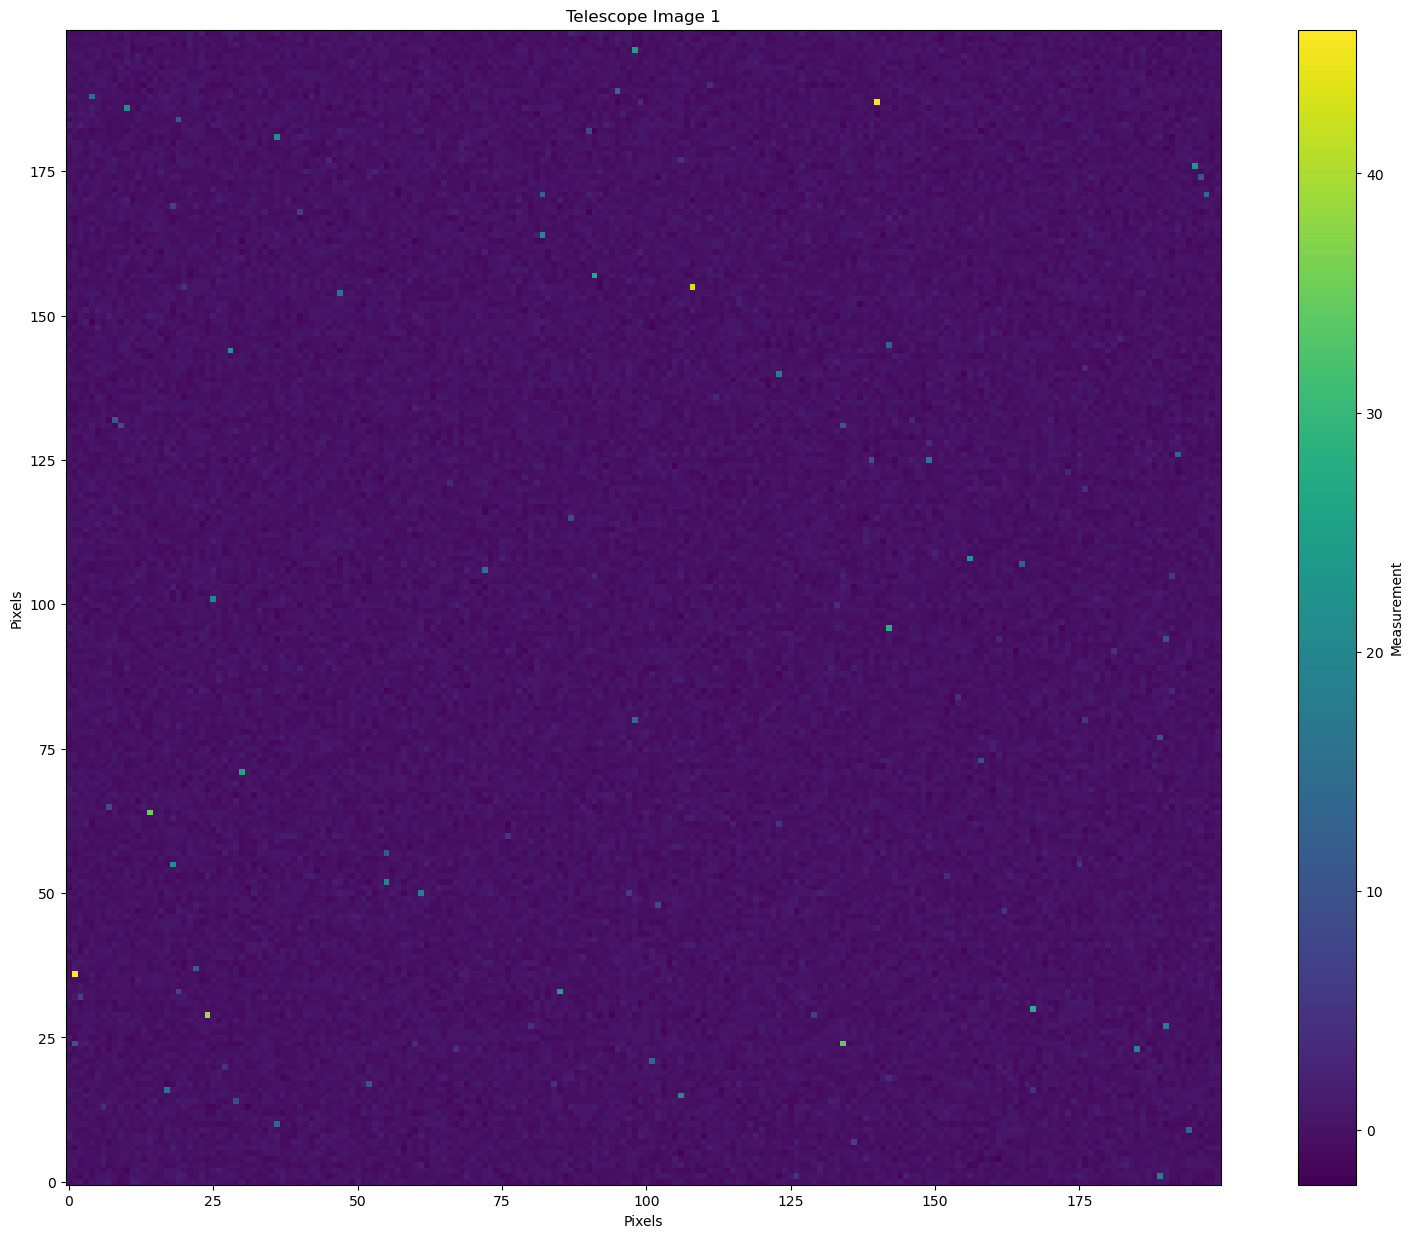

In [36]:
plt.title('Telescope Image 1')
plt.xlabel('Pixels')
plt.ylabel('Pixels')
plt.imshow(img_data[:, :, 0], origin = 'lower')
cbar = plt.colorbar()
cbar.set_label('Measurement')

Above is one part of the night sky's distribution (image 1).

Mean -0.003167586768696385, Std dev 0.5616091705025514


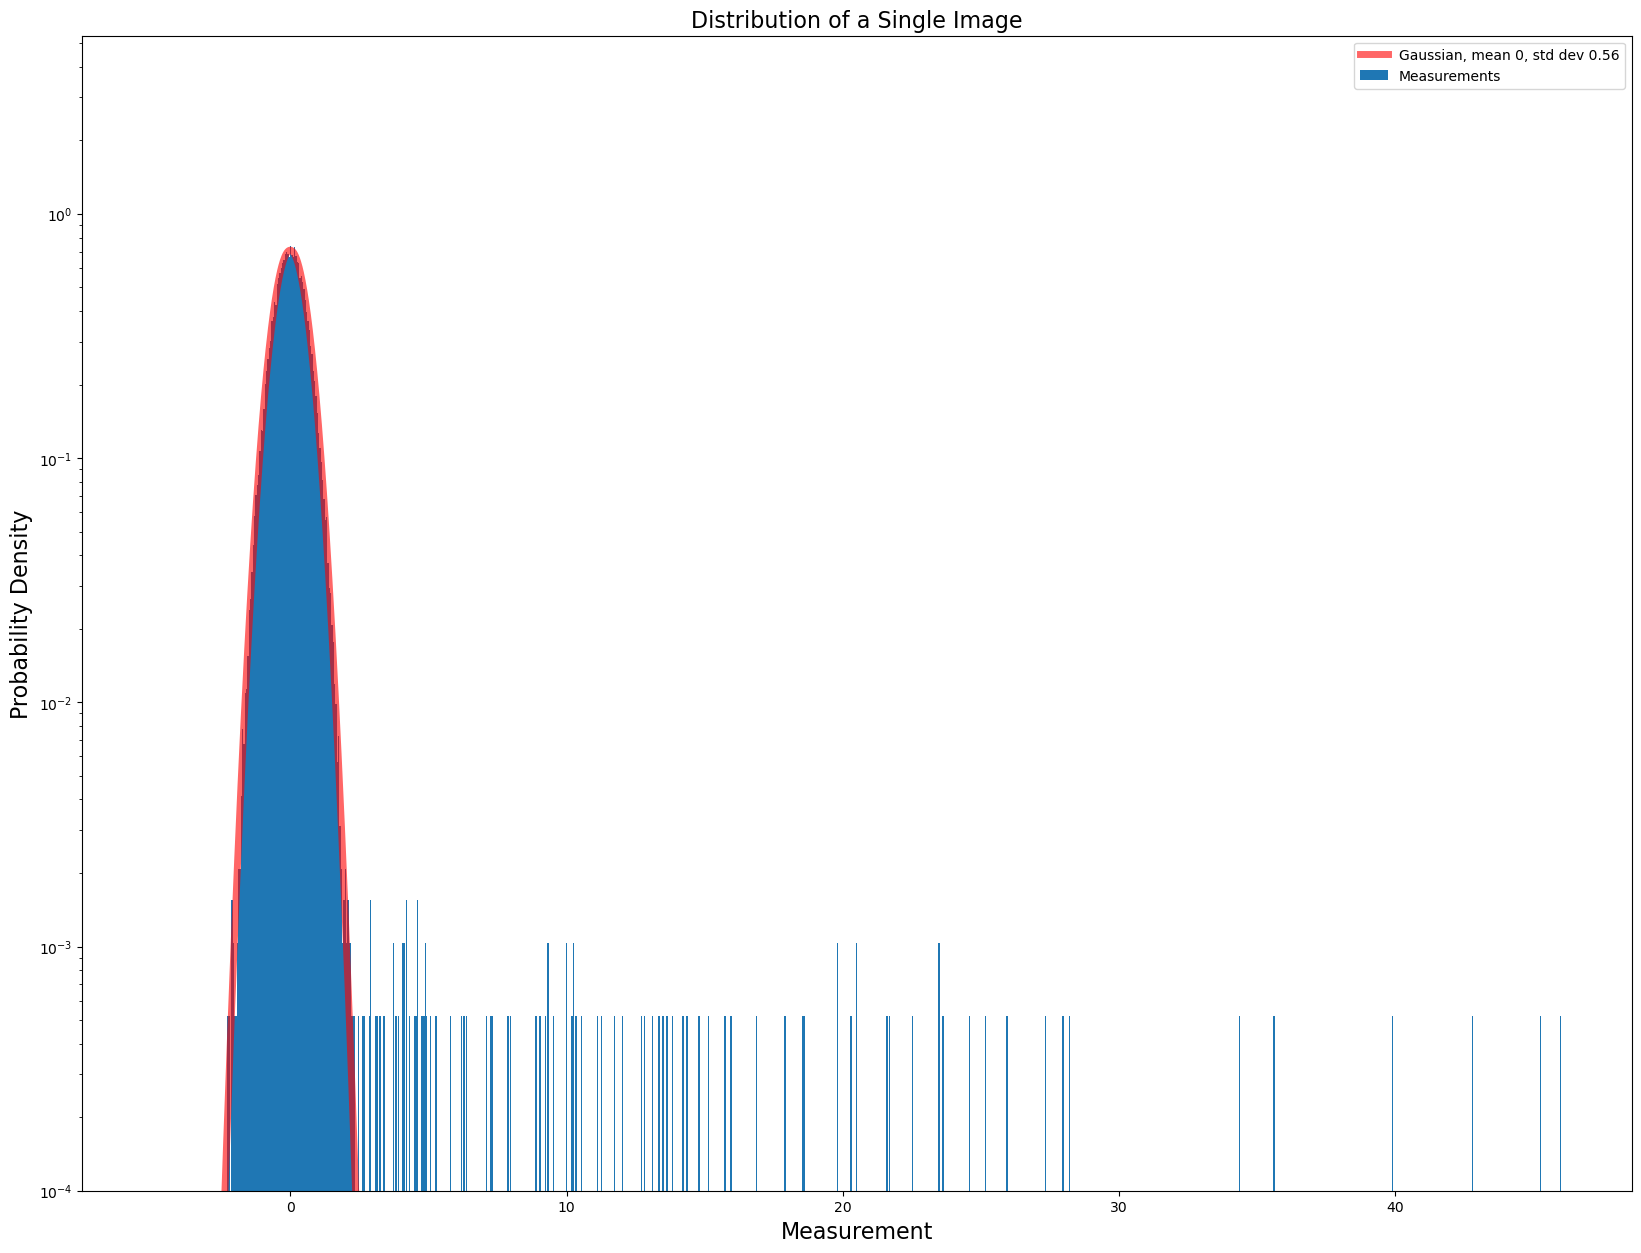

In [40]:
plt.title('Distribution of a Single Image' , fontsize = 16)
plt.xlabel('Measurement',  fontsize = 16)
plt.ylabel('Probability Density',  fontsize = 16)
image1_measurements = img_data[:, :, 0].flatten()
plt.hist(image1_measurements, bins=1000, density=True)
relevant_data_1 = image1_measurements[image1_measurements < 2]
mean = np.mean(relevant_data_1)
std_dev = np.std(relevant_data_1)
print(f"Mean {mean}, Std dev {std_dev}")
x = np.linspace(-5, 5, 1000)
y = stats.norm(mean, std_dev).pdf(x)
plt.plot(x, y, linewidth=5, alpha=0.6, color='r')
plt.yscale('log')
plt.ylim(1e-4, None)
plt.legend([f"Gaussian, mean 0, std dev {std_dev.round(2)}", 'Measurements']);

From the distribution above, it is clear that there is signal contamination in the image, which can be seen by the lines outside of the Gaussian curve. 

Mean -0.0001292660742716416, Std dev 0.1778348962220202


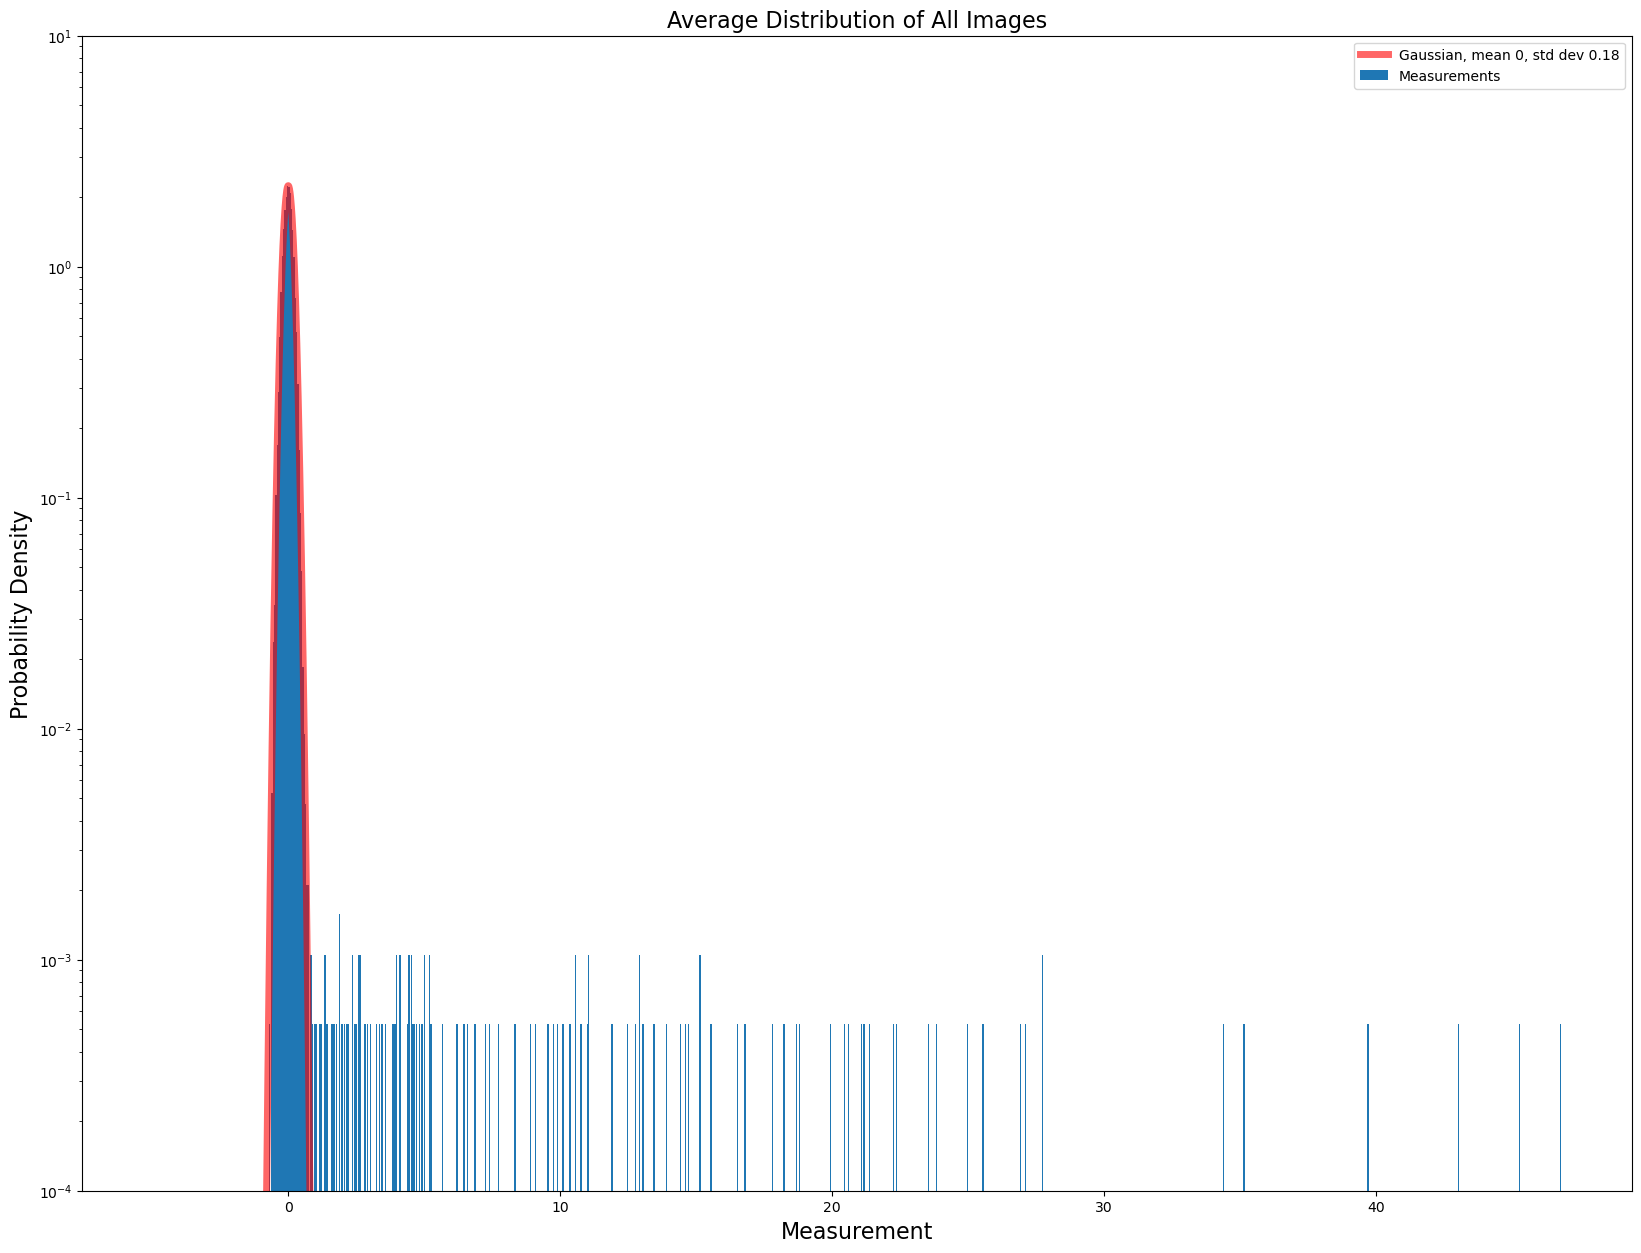

In [41]:
plt.title('Average Distribution of All Images', fontsize = 16)
plt.xlabel('Measurement', fontsize = 16)
plt.ylabel('Probability Density', fontsize = 16)
average_img = np.mean(img_data, axis=2)
plt.hist(average_img.flatten(), bins=1000, density=True)
relevant_data_avg = average_img[average_img < 1]
mean = np.mean(relevant_data_avg)
std_dev = np.std(relevant_data_avg)
print(f"Mean {mean}, Std dev {std_dev}")
x = np.linspace(-5, 5, 1000)
y = stats.norm(mean, std_dev).pdf(x)
plt.plot(x, y, linewidth=5, alpha=0.6, color='r')
plt.yscale('log')
plt.ylim(1e-4, 10)
plt.legend([f"Gaussian, mean 0, std dev {std_dev.round(2)}", 'Measurements']);

Above is the average distribution of all of the images, which again shows a Gaussian distribution with many lines outside of the Guassian curve. This time, the mean of the Gaussian remains the same, but the width of the curve has narrowed significantly. Because the mean of the distribution for all of the images is still at 0, it most likely that the background distribution is not time dependent. 

### 2.3:

In [42]:
threshold = stats.norm(mean, std_dev).ppf(stats.norm.cdf(5))
print(threshold)

0.8890452150305256


This means that a single measurement of 0.889 could be background measurement. However, an average of 0.889 for 10 images is not likely to be the background. Since there's no upper limit for significant measurement, we should restrict the upper bound so that the search window is for signals that are only slightly above 0.889 units.

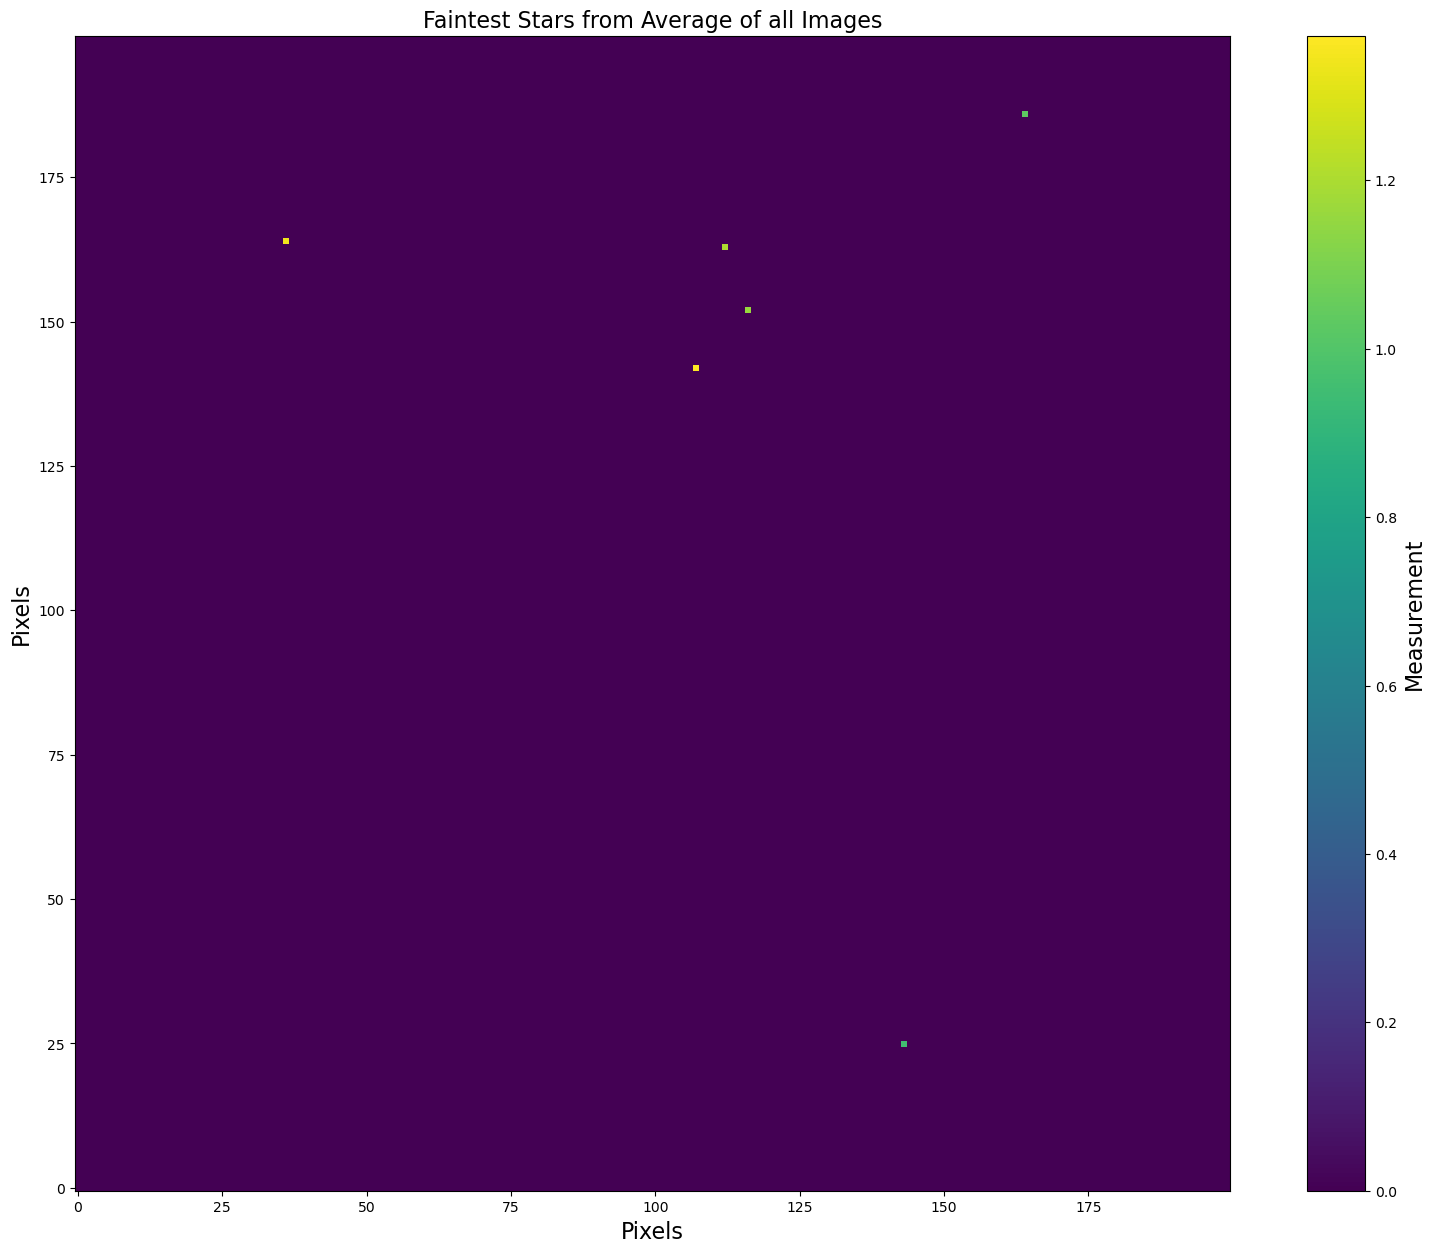

In [46]:
delta = 0.5
detections = (average_img > threshold) & (average_img < threshold + delta)
plt.title('Faintest Stars from Average of all Images', fontsize = 16)
plt.xlabel('Pixels', fontsize = 16)
plt.ylabel('Pixels', fontsize = 16)
plt.imshow(average_img * detections, origin='lower')
cbar = plt.colorbar()
cbar.set_label('Measurement', fontsize = 16)

### 2.4:

In the graph above is the brightness and location of the six faintest stars in that specific region of the sky. My partner looked for the brightest stars and it would look different since the background for the sum/difference will have a larger standard deviation, equal to $\sigma_k = \sqrt{\sigma_i^2 + \sigma_j^2}$. Therefore, his $5\sigma$ threshold will be larger, since the value of $\sigma$ is larger.